### Investigate max durations outliers in item attempt times
The duration between item attempt start and stop times have large number of outliers of over 100 minutes

In [2]:
%%capture

%run '../lib/libraries.ipynb'
from ..lib import utilities as util
from pyspark.sql import functions as F

In [41]:
filterDf = util.load_df('filterDf')
types = util.get_var_types()

intVars = ['student_start_datetime',
             'student_stop_datetime',
             'scored_datetime',
             'item_attempt_start_datetime_utc',
             'item_attempt_end_datetime_utc']

###### Dataframe of positive values

In [43]:
posDf = filterDf.filter( F.col('item_attempt_duration_mins') >= 0 )
posDf.count()

64830

###### Display problem

In [44]:
posDf.select('item_attempt_duration_mins').toPandas().describe()

,item_attempt_duration_mins
count,64830.000000
mean,535.355057
std,3429.858289
min,0.000000
25%,0.433333
50%,1.850000
75%,9.712500
max,109353.100000


- Max values over 100,000 above 3rd quartile

###### Histogram

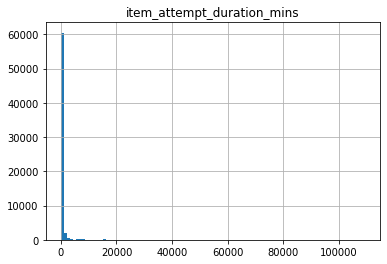

In [48]:
pdDf = posDf.select('item_attempt_duration_mins').toPandas()
ax = pdDf.hist(bins=100)

- Majority between 1 and 10
- Hard to visualize over 10

###### Histogram on logarithmic scale

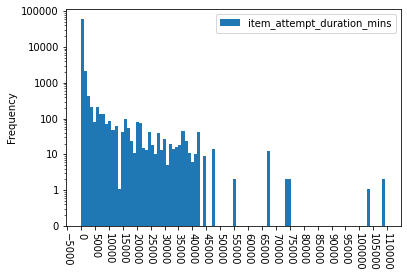

In [49]:
util.logrithmic_histogram(pdDf)

- Steady before 43,000
- Outliers after 43,000

###### Scatter plot of duration vs dates

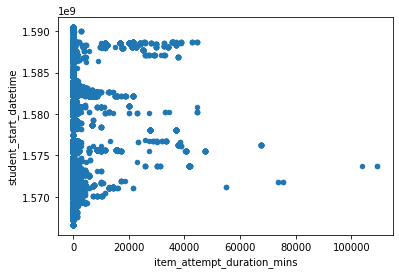

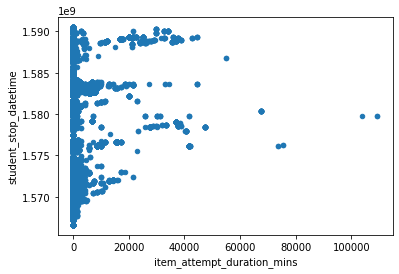

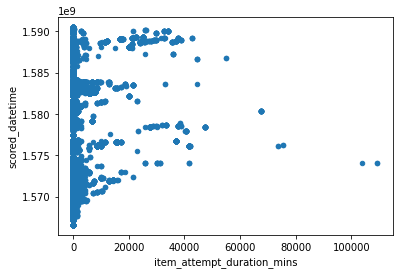

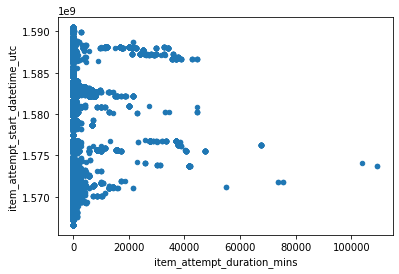

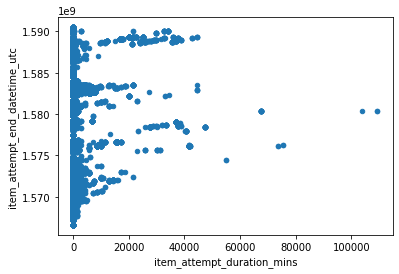

In [50]:
pdDf = posDf.select('item_attempt_duration_mins', * (F.unix_timestamp(c).alias(c) for c in intVars if c in posDf.columns) ).toPandas()

for c in intVars:
    ax = pdDf.plot('item_attempt_duration_mins', c, kind='scatter')

- Outliers visible
- Similar pattern between date variables
- Isolated instances above 50,000

###### Date boxplot of over 50,000

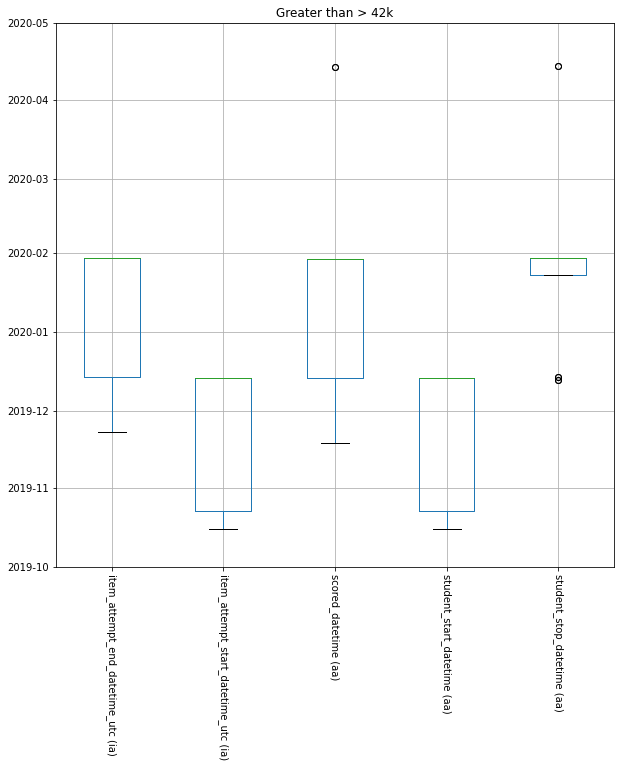

In [54]:
util.date_boxplot(posDf.filter( F.col('item_attempt_duration_mins') > 50000 ).select(*intVars), 'Greater than > 50k')

- stop dates end of January
- scored 1/15 to 2/1


###### Detect Outliers by Interquartile Range
- Formula: (Q3 + 1.5 IQR)

In [69]:
(lowFilter, highFilter, median) = util.get_iqr_filter(posDf, 'item_attempt_duration_mins')
highFilter

23.616666666666667

- Outliers > 23

###### Create outlier dataset

In [60]:
outDf = posDf.filter( F.col('item_attempt_duration_mins') > highFilter)
print ('Count', outDf.count())
print ('Percentage', round(outDf.count() / posDf.count() * 100))

Count 9324
Percentage 14


- 9,324
- 14% of dataset

###### Check dates distribution

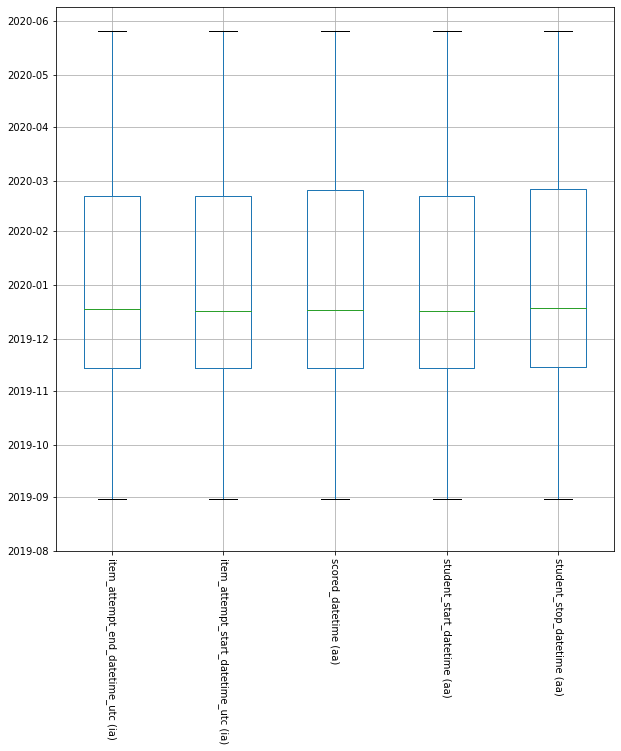

In [62]:
util.date_boxplot(outDf.select(*intVars), '')

- Median 12/15
- Majority between 11/15 to 2/20
  - Could be impacted by covid

##### Conclusion
- 14% of dataset has outliers
- Appear to be irregularity due to covid
- Impute with mean

###### Test Imputation

In [70]:
util.impute_item_attempt_duration(filterDf).select('item_attempt_duration_mins').toPandas().describe()

,item_attempt_duration_mins
count,64838.000000
mean,-2.494508
std,536.086521
min,-54766.016667
25%,0.433333
50%,1.850000
75%,3.483333
max,23.616667


- Outliers resolved

In [3]:
util.finish_todo('Investigate max durations outliers in item attempt times')
util.add_todo('Impute max durations outliers in item attempt times')

Finished: Investigate max durations outliers in item attempt times
Todo: Impute max durations outliers in item attempt times
